<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/process_segmentation_a_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yellowbrick
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors


from kneed import KneeLocator
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
import scipy.cluster.hierarchy as shc

In [3]:
data = pd.read_csv('./data/e-shop clothing 2008.csv', delimiter=';')
data.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  int64 
 1   month                    165474 non-null  int64 
 2   day                      165474 non-null  int64 
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  int64 
 5   session ID               165474 non-null  int64 
 6   page 1 (main category)   165474 non-null  int64 
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  int64 
 9   location                 165474 non-null  int64 
 10  model photography        165474 non-null  int64 
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  int64 
 13  page                     165474 non-null  int64 
dtypes: int64(13), object

- No hay valores nulos, hay una variedad de datos numeros, que deberian ser tipo texto

In [5]:
cat_vars = ['year', 'month', 'day', 'country', 'session ID',
               'page 1 (main category)', 'page 2 (clothing model)',   'colour',
               'location', 'model photography', 'price 2', 'page']

In [6]:
# Converción de variables categoricas
data[cat_vars] = data[cat_vars].astype(str)

In [7]:
# Datos descriptivos
data.describe()

,order,price
count,165474.000000,165474.000000
mean,9.817476,43.802507
std,13.478411,12.548131
min,1.000000,18.000000
25%,2.000000,33.000000
50%,6.000000,43.000000
75%,12.000000,52.000000
max,195.000000,82.000000


- La magnitud de precios tiene una diferencia pronunciada, en comparación a order

In [8]:
data2 = data.groupby(['country','page 1 (main category)','page 2 (clothing model)']).agg(
    median_no_of_clicks_per_session=('order', 'median'),
    min_no_of_clicks_per_session = ('order', 'max'),
    max_no_of_clicks_per_session = ('order', 'min'),
    median_price=('price', 'median'),
    min_price=('price', 'max'),
    max_price=('price', 'min'),
    total_number_of_sessions =('session ID', pd.Series.nunique),
    most_frequent_day=('day', lambda x: mode(x)[0][0]),
    most_frequent_colour=('colour', lambda x: mode(x)[0][0]),
    most_frequent_location=('location', lambda x: mode(x)[0][0]),
    most_frequent_photo_type=('model photography', lambda x: mode(x)[0][0]),
    most_frequent_price_type =('price 2', lambda x: mode(x)[0][0]),
    most_frequent_page_number =('page', lambda x: mode(x)[0][0])
)

In [9]:
data2

median_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                    
1       3                      C30                                                  2.0   
        4                      P17                                                  2.0   
10      1                      A1                                                   2.0   
                               A11                                                  2.0   
                               A12                                                  3.0   
...                                                                                 ...   
9       4                      P77                                                 18.0   
                               P78                                                  6.5   
                               P80                                                 96.0   
                               P82                                                 17.5   
                               P9                                                   3.0   

                                                        min_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 3   
10      1                      A1                                                  2   
                               A11                                                 3   
                               A12                                                 5   
...                                                                              ...   
9       4                      P77                                                18   
                               P78                                                95   
                               P80                                                96   
                               P82                                                18   
                               P9                                                  4   

                                                        max_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 1   
10      1                      A1                                                  2   
                               A11                                                 1   
                               A12                                                 1   
...                                                                              ...   
9       4                      P77                                                18   
                               P78                                                 1   
                               P80                                                96   
                               P82                                                17   
                               P9                                                  1   

                                                        median_price  \
country page 1 (main category) page 2 (clothing model)                 
1       3                      C30                              28.0   
        4                      P17                              38.0   
10      1                      A1                               28.0   
                               A11                              62.0   
                               A12                              38.0   
...                                                              ...   
9     

- No hay variables categoricas que tengan naturaleza ordinasl, se puede tratar con variables categoricas dummy

In [10]:
cat_vars = ['most_frequent_day',
           'most_frequent_colour', 'most_frequent_location',
           'most_frequent_photo_type', 'most_frequent_price_type',
           'most_frequent_page_number']

data2[cat_vars] = data2[cat_vars].astype(str)
data3 = pd.get_dummies(data2)
data3

median_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                    
1       3                      C30                                                  2.0   
        4                      P17                                                  2.0   
10      1                      A1                                                   2.0   
                               A11                                                  2.0   
                               A12                                                  3.0   
...                                                                                 ...   
9       4                      P77                                                 18.0   
                               P78                                                  6.5   
                               P80                                                 96.0   
                               P82                                                 17.5   
                               P9                                                   3.0   

                                                        min_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 3   
10      1                      A1                                                  2   
                               A11                                                 3   
                               A12                                                 5   
...                                                                              ...   
9       4                      P77                                                18   
                               P78                                                95   
                               P80                                                96   
                               P82                                                18   
                               P9                                                  4   

                                                        max_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 1   
10      1                      A1                                                  2   
                               A11                                                 1   
                               A12                                                 1   
...                                                                              ...   
9       4                      P77                                                18   
                               P78                                                 1   
                               P80                                                96   
                               P82                                                17   
                               P9                                                  1   

                                                        median_price  \
country page 1 (main category) page 2 (clothing model)                 
1       3                      C30                              28.0   
        4                      P17                              38.0   
10      1                      A1                               28.0   
                               A11                              62.0   
                               A12                              38.0   
...                                                              ...   
9     

In [11]:
# Estandarización
num_vars = ['median_no_of_clicks_per_session', 'min_no_of_clicks_per_session', 
           'max_no_of_clicks_per_session', 'median_price', 'min_price', 
           'max_price', 'total_number_of_sessions']
estimator = StandardScaler()

data3[num_vars] = estimator.fit_transform(data3[num_vars])
data3.head(5)

median_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                    
1       3                      C30                                            -0.784923   
        4                      P17                                            -0.784923   
10      1                      A1                                             -0.784923   
                               A11                                            -0.784923   
                               A12                                            -0.686829   

                                                        min_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                         -0.740009   
        4                      P17                                         -0.715043   
10      1                      A1                                          -0.740009   
                               A11                                         -0.715043   
                               A12                                         -0.665109   

                                                        max_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                         -0.445811   
        4                      P17                                         -0.550030   
10      1                      A1                                          -0.445811   
                               A11                                         -0.550030   
                               A12                                         -0.550030   

                                                        median_price  \
country page 1 (main category) page 2 (clothing model)                 
1       3                      C30                         -1.197785   
        4                      P17                         -0.367561   
10      1                      A1                          -1.197785   
                               A11                          1.624976   
                               A12                         -0.367561   

                                                        min_price  max_price  \
country page 1 (main category) page 2 (clothing model)                         
1       3                      C30                      -1.197785  -1.197785   
        4                      P17                      -0.367561  -0.367561   
10      1                      A1                       -1.197785  -1.197785   
                               A11                       1.624976   1.624976   
                               A12                      -0.367561  -0.367561   

                                                        total_number_of_sessions  \
country page 1 (main category) page 2 (clothing model)                             
1       3                      C30                                     -0.254235   
        4                      P17                                     -0.254235   
10      1                      A1                                      -0.254235   
                               A11                                     -0.248735   
                               A12                                     -0.232237   

                                                        most_frequent_day_1  \
country page 1 (main category) page 2 (clothing model)                        
1       3                      C30                                        0   
        4                      P17                                        0   
10      1                      A1                                         0   
                               A11                                        0   
                               A12                     

In [12]:
# Componentes principales

# Identificar que componentes explican el 85% de la variabilidad
final_comp = 0
for comp in range(3, data3.shape[1]):
  pca = PCA(n_components=comp, random_state=42)
  pca.fit(data3)
  comp_check = pca.explained_variance_ratio_
  final_comp = comp
  if comp_check.sum() > 0.85:
    break

  

final_pca = PCA(n_components=final_comp, random_state=42)
final_pca.fit(data3)
cluster_df=final_pca.transform(data3)
num_comps = comp_check.shape[0]

print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

Using 15 components, we can explain 0.8521121438333596% of the variability in the original data.


# **Selection of the best k (number of cluster)**
---

# **Kmeans**
---

**Gap Statistic**
---

In [13]:
def estimator_gap(data, nrefs, max_cluster, model):
  """ 
    Calcula KMeans K óptimo usando Gap Statistic 
    Params: 
        data: cantidad de forma (n_samples, n_features) 
        nrefs: número de conjuntos de datos de referencia de muestra para crear 
        maxClusters: número máximo de clústeres para probar 
  """
  
  range_clusters = range(1, max_cluster)
  gaps = np.zeros((len(range_clusters),))
  iter = pd.DataFrame({'num_cluster':[], 'gap':[]})
  for gap_index, k in enumerate(range_clusters):
    # Soporte para resultados de dispersión de referencia
    ref_disps = np.zeros(nrefs)
    # Para n referencias, genera una muestra aleatoria y realiza un modelo como kmeans obteniendo la dispersión resultante de cada ciclo
    for i in range(nrefs):
      # conjunto de datos de referencia
      random_reference = np.random.random_sample(size=data.shape)
      model = model.set_params(n_clusters = k)
      model.fit(random_reference)
      disp_ref = model.inertia_
      ref_disps[i] = disp_ref
    # Ajuste el clúster a los datos originales y cree dispersión
    model = model.set_params(n_clusters = k)
    model.fit(data)
    orig_disp = model.inertia_
    # Calculate gap statistic
    gap = np.log(np.mean(ref_disps)) - np.log(orig_disp)
    #Calculate gap statistic
    gaps[gap_index] = gap
    iter = iter.append({'num_cluster':k, 'gap':gap}, ignore_index=True)
  return (gaps.argmax() + 1, iter)


In [14]:
score_g, df = estimator_gap(cluster_df, 5, 30, KMeans())

In [15]:
df['num_cluster'] = df['num_cluster'].astype(int) 
print(f'Número de clusters según el metodo gap: {score_g}')

Número de clusters según el metodo gap: 29


In [16]:
best_gab = df[df['num_cluster']==score_g].values[0]
best_gab

array([29.        , -1.05943952])

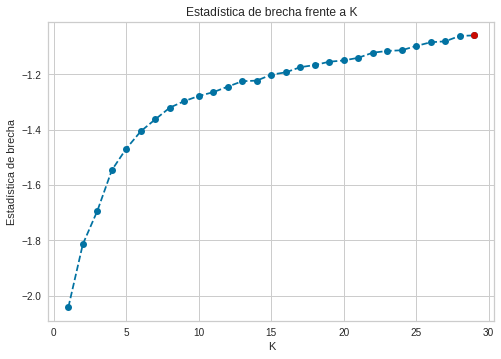

In [17]:
plt.plot(df['num_cluster'], df['gap'], linestyle='--', marker='o', color='b'); 
plt.plot(best_gab[0], best_gab[1], marker='o', color='r'); 
plt.xlabel('K'); 
plt.ylabel('Estadística de brecha'); 
plt.title('Estadística de brecha frente a K');

- El estimador gap se maximizan con 29 grupos y, por lo tanto, podemos elegir 29 grupos para nuestras K medias.

**Elbow Method**
---

In [18]:
def cluste_method_plot(model, data, k, metric='distortion', distance_metric='euclidean', timings=True):
  visualizer = KElbowVisualizer(model, k=k, timings=timings, metric=metric, distance_metric=distance_metric)
  visualizer.fit(data)
  visualizer.show()

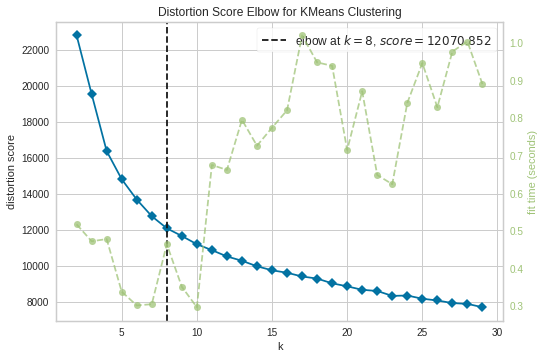

In [19]:
model = KMeans()
cluste_method_plot(model, cluster_df, k=(2,30), timings=True)

La KElbowVisualizerfunción se ajusta al KMeansmodelo para un rango de valores de conglomerados entre 2 y 30. Como se muestra en la Figura, el punto de codo se logra con 8 conglomerados que se destaca por la propia función. La función también nos informa sobre cuánto tiempo se necesitó para trazar modelos para varios números de conglomerados a través de la línea verde.

**Silhouette Coefficient**
---


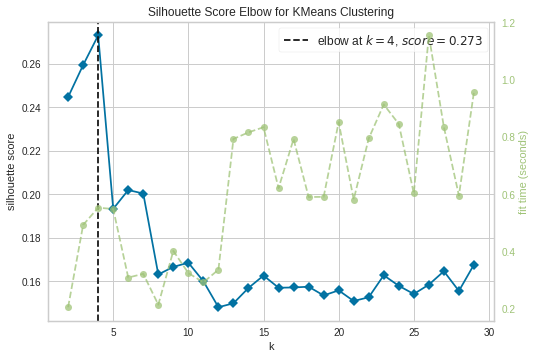

In [20]:
cluste_method_plot(model, cluster_df, k=(2,30), timings=True, metric='silhouette')

El número óptimo de clústeres basado en Silhouette Score es 4.



**Calinski-Harabasz Index**
---

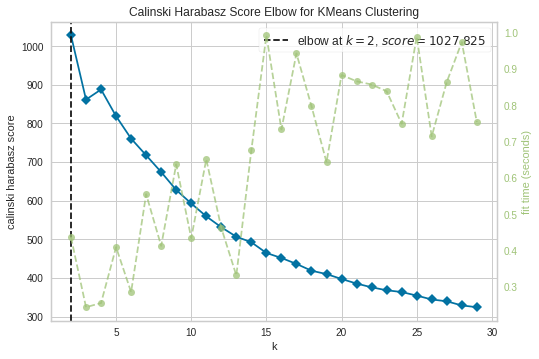

In [21]:
cluste_method_plot(model, cluster_df, k=(2,30), timings=True, metric='calinski_harabasz')

el índice de Calinski Harabasz se maximiza cuando el número de grupos es 2 para el algoritmo de agrupamiento de K significa. 

**Davies-Bouldin Index**
---

In [22]:
def get_davies_bouldin(data, center, model):
    model = model.set_params(n_clusters=center)
    model = model.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

scores = []
centers = []
for center in range(2,30):
    scores.append(get_davies_bouldin(cluster_df, center, KMeans()))
    centers.append(center)

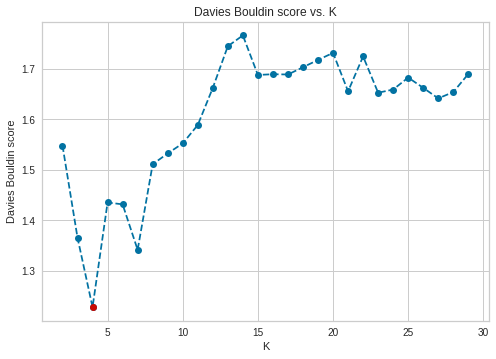

In [23]:
pos = pd.Series(scores).argmin()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.plot(centers[pos], scores[pos], linestyle='--', marker='o', color='r');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

In [24]:
centers[pos]

4

Como se ve en la Figura 5, la puntuación de Davies Bouldin se minimiza con 4 grupos y se puede considerar para el algoritmo de k medias

**Dendograma**
---

In [25]:
# Dendogram for Heirarchical Clustering
def plot_dendograma(data):
  plt.figure(figsize=(10, 7))  
  plt.title("Dendrograms")  
  dend = shc.dendrogram(shc.linkage(data, method='ward'))
  return np.unique(dend['color_list']).shape[0]

4

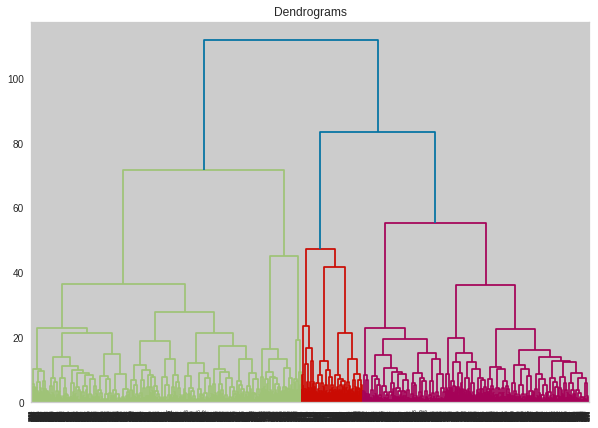

In [26]:
plot_dendograma(cluster_df)

**Bayesian information criterion**
---

In [27]:
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov)
        gmm.fit(cluster_df)
        score.append((cov,n_comp,gmm.bic(cluster_df)))
score

[('spherical', 1, 112956.25874655996),
 ('spherical', 2, 102376.77863113278),
 ('spherical', 3, 90546.4699402852),
 ('spherical', 4, 86829.96689931279),
 ('spherical', 5, 83703.84537557479),
 ('spherical', 6, 82880.81206647074),
 ('spherical', 7, 81393.48335570341),
 ('spherical', 8, 80606.9736425881),
 ('spherical', 9, 78127.62985146415),
 ('spherical', 10, 77832.88954855585),
 ('spherical', 11, 76516.29425367597),
 ('spherical', 12, 75879.02791792521),
 ('spherical', 13, 75316.09702785352),
 ('spherical', 14, 73887.83402381858),
 ('spherical', 15, 74572.23222042901),
 ('spherical', 16, 72612.9550100807),
 ('spherical', 17, 72693.42619931836),
 ('spherical', 18, 72810.44654804106),
 ('spherical', 19, 72014.87533693622),
 ('spherical', 20, 71496.17353387031),
 ('spherical', 21, 70522.64487965571),
 ('spherical', 22, 70590.79851557093),
 ('spherical', 23, 70394.07333796367),
 ('spherical', 24, 69899.27469452894),
 ('spherical', 25, 68719.59290287492),
 ('spherical', 26, 69133.8208596562

- Codo método: 8
- Estadística de brecha: 29
- Puntuación de la silueta: 4
- Calinski Harabasz puntuación: 2
- Puntuación de Davies Bouldin: 4

In [28]:
model = KMeans(n_clusters=4, random_state=10)

In [29]:
y_predict = model.fit_predict(cluster_df)

In [30]:
pd.Series(y_predict).value_counts()

3    1418
2    1222
1     256
0     245
dtype: int64

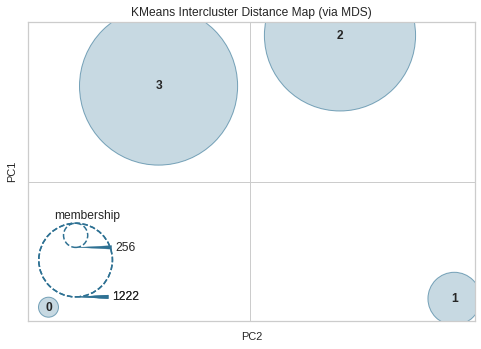

In [31]:
inter_cluster_distance_map = InterclusterDistance(model)
inter_cluster_distance_map.fit(cluster_df)
inter_cluster_distance_map.show()

dos grupos son bastante grandes en comparación con los demás y parecen tener una separación decente entre ellos. Sin embargo, si dos clústeres se superponen en el espacio 2D, no implica que se superpongan en el espacio de características original. 

In [32]:
score_c = calinski_harabasz_score(cluster_df, model.labels_)
score_d = davies_bouldin_score(cluster_df, y_predict)
score_s = silhouette_score(cluster_df, model.labels_, metric='euclidean')

print('Silhouette Score: %.4f' % score_s)
print('Calinski Harabasz Score: %.4f' % score_c)
print('Davies Bouldin Score: %.4f' % score_d)

Silhouette Score: 0.2733
Calinski Harabasz Score: 887.8306
Davies Bouldin Score: 1.2287


## **AgglomerativeClustering**
---

In [33]:
model = AgglomerativeClustering()

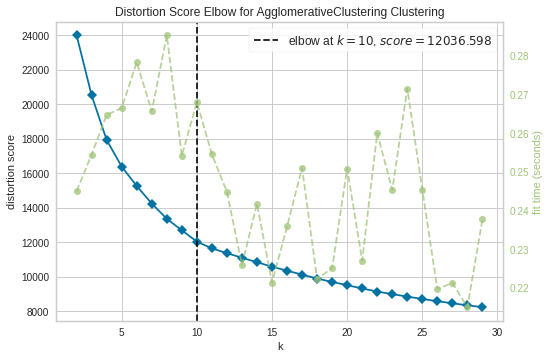

In [34]:
cluste_method_plot(model, cluster_df, k=(2,30), timings=True)

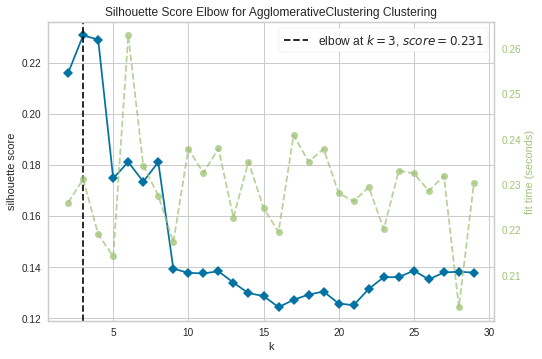

In [35]:
cluste_method_plot(model, cluster_df, k=(2,30), timings=True, metric='silhouette')

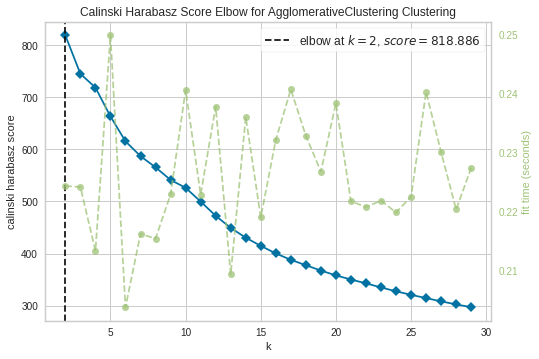

In [36]:
cluste_method_plot(model, cluster_df, k=(2,30), timings=True, metric='calinski_harabasz')

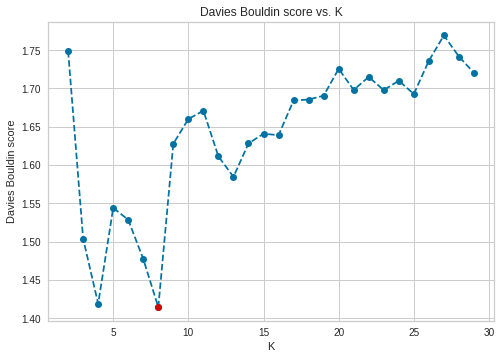

In [37]:
def get_davies_bouldin(data, center, model):
    model = model.set_params(n_clusters=center)
    model = model.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

scores = []
centers = []
for center in range(2,30):
    scores.append(get_davies_bouldin(cluster_df, center, model))
    centers.append(center)

pos = pd.Series(scores).argmin()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.plot(centers[pos], scores[pos], linestyle='--', marker='o', color='r');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

In [38]:
centers[pos]

8

- Codo método: 10
- Puntuación de la silueta: 3
- Calinski Harabasz puntuación: 2
- Puntuación de Davies Bouldin: 8



In [39]:
model = AgglomerativeClustering(n_clusters=4)
prediction = model.fit_predict(cluster_df)

In [40]:
clusters = np.unique(prediction)
clusters

array([0, 1, 2, 3])

In [41]:
metricsscore_AGclustering_s = silhouette_score(cluster_df, model.labels_, metric='euclidean')
score_AGclustering_c =  calinski_harabasz_score(cluster_df, model.labels_)
core_AGclustering_d = davies_bouldin_score(cluster_df, model.labels_)

In [42]:
print('Silhouette Score: %.4f' % metricsscore_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % core_AGclustering_d)

Silhouette Score: 0.2291
Calinski Harabasz Score: 718.8155
Davies Bouldin Score: 1.4191


K-means supera el agrupamiento aglomerativo en función de todas las métricas de validación del clúster.

# **DBSCAN**
---

**ajuste de parametros**

- minPts:  el número mínimo de puntos (un umbral) agrupados para que una región se considere densa.
- eps (ε):  Una medida de distancia que se utilizará para ubicar los puntos en la vecindad de cualquier punto.





Para ajustar los parámetros del modelo, primero identificamos el  eps valor óptimo encontrando la distancia entre los vecinos de un punto y trazando la distancia mínima. Esto nos da la curva de codo para encontrar la densidad de los puntos de datos y el  eps valor óptimo se puede encontrar en el punto de inflexión. 

1.933581641310734


<Figure size 360x360 with 0 Axes>

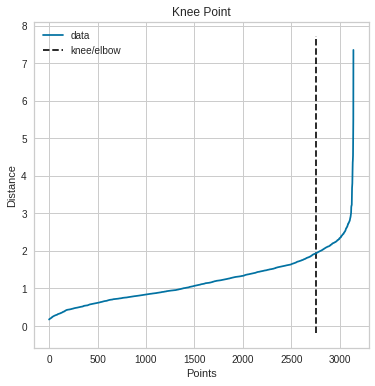

In [45]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(cluster_df)
distances, indices = neighbors.kneighbors(cluster_df)
distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

el valor óptimo para  eps es 1.933581641310734

Usamos este valor para el parámetro en el futuro e intentamos encontrar el valor óptimo del  min_samples parámetro en función de la puntuación de Silhouette, la puntuación de Calinski Harabasz y la puntuación de Davies Bouldin. Para cada uno de estos métodos, el número óptimo de grupos es el siguiente

- Puntuación de la silueta: 18
- Puntuación de Calinski Harabasz: 29
- Puntuación de Davies Bouldin: 2

Toca realizar implementaciones en python, ya que el metodo de visualization no permite parametros que no esten asociados a KMEANS

In [67]:
model = DBSCAN(eps=1.9335816413107338)

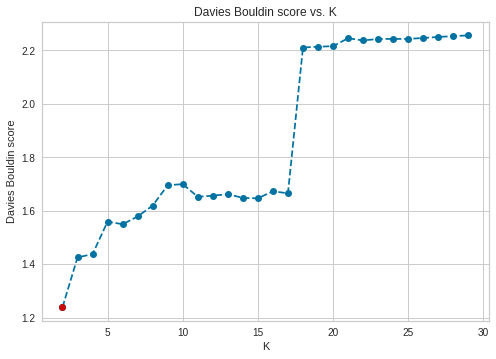

In [68]:
def get_davies_bouldin(data, center, model):
    model = model.set_params(min_samples=center)
    model = model.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

scores = []
centers = []
for center in range(2,30):
    scores.append(get_davies_bouldin(cluster_df, center, model))
    centers.append(center)

pos = pd.Series(scores).argmin()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.plot(centers[pos], scores[pos], linestyle='--', marker='o', color='r');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

In [69]:
centers[pos]

2

In [73]:
model = DBSCAN(eps=1.9335816413107338, min_samples=18)
y_predict = model.fit_predict(cluster_df)

In [74]:
clusters = np.unique(y_predict)

In [75]:
metricsscore_AGclustering_s = silhouette_score(cluster_df, model.labels_, metric='euclidean')
score_AGclustering_c =  calinski_harabasz_score(cluster_df, model.labels_)
core_AGclustering_d = davies_bouldin_score(cluster_df, model.labels_)

In [76]:
print('Silhouette Score: %.4f' % metricsscore_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % core_AGclustering_d)

Silhouette Score: 0.3782
Calinski Harabasz Score: 345.2103
Davies Bouldin Score: 2.2108


DBSCAN funciona mejor que K-means en la puntuación de Silhouette. 

In [ ]:
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# define dataset
# define the model
model = DBSCAN(eps=1.9335816413107338, min_samples= 18)# rule of thumb for min_samples: 2*len(cluster_df.columns)# fit model and predict clusters
yhat = model.fit_predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)# Calculate cluster validation metricsscore_dbsacn_s = silhouette_score(cluster_df, yhat, metric='euclidean')score_dbsacn_c = calinski_harabasz_score(cluster_df, yhat)score_dbsacn_d = davies_bouldin_score(cluster_df, yhat)print('Silhouette Score: %.4f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.4f' % score_dbsacn_c)
print('Davies Bouldin Score: %.4f' % score_dbsacn_d)

In [ ]:
cluste_method_plot

In [63]:
model = DBSCAN()

In [ ]:
model = DBSCAN(eps=1.9335816413107338, min_samples= 18)# rule of thumb for min_samples: 2*len(cluster_df.columns)# fit model and predict clusters
yhat = model.fit_predict(cluster_df)

# **Referencias**
---

- Datos
  - https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping

